# Creating Spark Session

In [1]:
#Creating Spark Session
from pyspark.sql import SparkSession
sc= SparkSession.builder.appName('book_crossing').getOrCreate()

In [2]:
#importing libraries
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
import pandas as pd

In [3]:
#Loading the CSV files
books = sc.read.csv("Books.csv",header = True,sep=';', inferSchema = True)
ratings = sc.read.csv("Ratings.csv",header = True,sep=';', inferSchema = True)
#users = sc.read.csv("Users.csv",header = True,sep=';', inferSchema = True)


# 1.1: EDA

### Books.csv

In [4]:
#printing the schema
books.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Publisher: string (nullable = true)



In [5]:
#Dataframe
books.show(5)

+----------+--------------------+--------------------+----+--------------------+
|      ISBN|               Title|              Author|Year|           Publisher|
+----------+--------------------+--------------------+----+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|2002|Oxford University...|
|0002005018|        Clara Callan|Richard Bruce Wright|2001|HarperFlamingo Ca...|
|0060973129|Decision in Normandy|        Carlo D'Este|1991|     HarperPerennial|
|0374157065|Flu: The Story of...|    Gina Bari Kolata|1999|Farrar Straus Giroux|
|0393045218|The Mummies of Ur...|     E. J. W. Barber|1999|W. W. Norton & Co...|
+----------+--------------------+--------------------+----+--------------------+
only showing top 5 rows



#### No.of rows

In [19]:
#No.of rows
books.count()

271379

#### No.of  columns

In [6]:
print("No.of columns:",len(books.columns))

No.of columns: 5


#### Checking Null Values

In [7]:
books.filter(F.isnull("Title")).count()

0

In [8]:
books.filter(F.isnull("Author")).count()

4

In [9]:
books.filter(F.isnull("Year")).count()

6

In [10]:
books.filter(F.isnull("Publisher")).count()

8

- There are only few null values, so we will drop them which will doesn't affect the analysis.

In [11]:
#Dropping null values
books= books.na.drop()

In [12]:
#No.of rows in books dataframe after dropping nan values
books.count()

271370

####  No.of Authors

In [26]:
books.select("Author").distinct().count()

102031

#### Year Column

In [27]:
books.select("Year").distinct().show()

+-------------------+
|               Year|
+-------------------+
|               1953|
|               1957|
|               1897|
|               1987|
|               1956|
|               1936|
|               2020|
|               2012|
|               1958|
|               1910|
|               1943|
|               1972|
|John Alderson Foote|
|               1931|
|               2026|
|               1988|
|               1926|
|               1938|
|               1911|
|               1932|
+-------------------+
only showing top 20 rows



- There are values other than Year of book published, and in the publisher column there are numbers, so will find them and drop from the dataframe

In [13]:
def is_digit(val):
    if val:
        return val.isdigit()
    else:
        return False

is_digit_udf = udf(is_digit, BooleanType())

books = books.withColumn('y_Value', F.when(is_digit_udf(F.col('Year')), F.lit(True)).otherwise(F.lit(False)))
books = books.withColumn('P_Value', F.when(is_digit_udf(F.col('Publisher')), F.lit(True)).otherwise(F.lit(False)))

In [15]:
books.show(5)

+----------+--------------------+--------------------+----+--------------------+-------+-------+
|      ISBN|               Title|              Author|Year|           Publisher|y_Value|P_Value|
+----------+--------------------+--------------------+----+--------------------+-------+-------+
|0195153448| Classical Mythology|  Mark P. O. Morford|2002|Oxford University...|   true|  false|
|0002005018|        Clara Callan|Richard Bruce Wright|2001|HarperFlamingo Ca...|   true|  false|
|0060973129|Decision in Normandy|        Carlo D'Este|1991|     HarperPerennial|   true|  false|
|0374157065|Flu: The Story of...|    Gina Bari Kolata|1999|Farrar Straus Giroux|   true|  false|
|0393045218|The Mummies of Ur...|     E. J. W. Barber|1999|W. W. Norton & Co...|   true|  false|
+----------+--------------------+--------------------+----+--------------------+-------+-------+
only showing top 5 rows



In [16]:
#Showing the dataframe where Year is not numeric.
books.filter(books.y_Value == 'false').show()

+----------+--------------------+--------------------+--------------------+---------------+-------+-------+
|      ISBN|               Title|              Author|                Year|      Publisher|y_Value|P_Value|
+----------+--------------------+--------------------+--------------------+---------------+-------+-------+
|0330482750|"Three Novels: ""...| \""Afternoon Raa...| \""Freedom Song\"""| Amit Chaudhuri|  false|  false|
|8423920143|"GuÃ­a del lector...|       14 : Ensayo)"|Salvador de Madar...|           1976|  false|   true|
|0553570722|"""R\"" for Reven...| Created by Franc...|     Francine Pascal|           1997|  false|   true|
|085409878X|    """Pie-powder\""| being dust from ...| John Alderson Foote|           1973|  false|   true|
|0006479839|"The LaVyrle Spen...| \""Forsaking All...| & \""A Promise t...|LaVyrle Spencer|  false|  false|
|0807735132|"""The Having of ...|           Learning"|   Eleanor Duckworth|           1996|  false|   true|
|006263545X|"Ludwig van Beet

In [17]:
# books dataframe where Publisher values of different datatype
books.filter(books.P_Value == 'true').show()

+----------+--------------------+--------------------+--------------------+---------+-------+-------+
|      ISBN|               Title|              Author|                Year|Publisher|y_Value|P_Value|
+----------+--------------------+--------------------+--------------------+---------+-------+-------+
|0967389305|Restoring Intimac...|         Drew Pinsky|                1999|        3|   true|   true|
|8423920143|"GuÃ­a del lector...|       14 : Ensayo)"|Salvador de Madar...|     1976|  false|   true|
|0553570722|"""R\"" for Reven...| Created by Franc...|     Francine Pascal|     1997|  false|   true|
|2264034173| Un troublant retour|  Patricia Wentworth|                2002|    37547|   true|   true|
|085409878X|    """Pie-powder\""| being dust from ...| John Alderson Foote|     1973|  false|   true|
|0807735132|"""The Having of ...|           Learning"|   Eleanor Duckworth|     1996|  false|   true|
|2264033932|         David Bowie|JÃ?Â©rÃ?Â´me Soligny|                2002|    375

In [18]:
books_df = books.where(books.y_Value == 'true')
books_df = books_df.where(books.P_Value == 'false')

In [19]:
#No.of rows after filtering the books dataframe
books_df.count()

271360

In [20]:
#checking if there are still any values other than year values in the Year column
books_df.filter(books_df.y_Value == 'false').show()

+----+-----+------+----+---------+-------+-------+
|ISBN|Title|Author|Year|Publisher|y_Value|P_Value|
+----+-----+------+----+---------+-------+-------+
+----+-----+------+----+---------+-------+-------+



In [21]:
#Checking iof there are any values other than Publisher in the Publisher Column.
books_df.filter(books_df.P_Value == 'true').show()

+----+-----+------+----+---------+-------+-------+
|ISBN|Title|Author|Year|Publisher|y_Value|P_Value|
+----+-----+------+----+---------+-------+-------+
+----+-----+------+----+---------+-------+-------+



In [22]:
#We Dont need y_Value and P_Value columns, So we drop these columns from the books DataFrame
col_to_drop=['y_Value','P_Value']
books_df= books_df.drop(*col_to_drop)

In [26]:
#Coverting Year to Integer Type
books_df = books_df.withColumn("Year", books_df["Year"].cast(IntegerType()))

In [27]:
#Let us see the books DataFrame after dropping the columns
books_df.show(2)

+----------+-------------------+--------------------+----+--------------------+
|      ISBN|              Title|              Author|Year|           Publisher|
+----------+-------------------+--------------------+----+--------------------+
|0195153448|Classical Mythology|  Mark P. O. Morford|2002|Oxford University...|
|0002005018|       Clara Callan|Richard Bruce Wright|2001|HarperFlamingo Ca...|
+----------+-------------------+--------------------+----+--------------------+
only showing top 2 rows



In [28]:
books_df.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Publisher: string (nullable = true)



### Ratings.csv

In [29]:
ratings.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Rating: integer (nullable = true)



In [30]:
ratings.show(5)

+-------+----------+------+
|User-ID|      ISBN|Rating|
+-------+----------+------+
| 276725|034545104X|     0|
| 276726|0155061224|     5|
| 276727|0446520802|     0|
| 276729|052165615X|     3|
| 276729|0521795028|     6|
+-------+----------+------+
only showing top 5 rows



In [31]:
ratings = ratings.withColumnRenamed('User-ID', 'User_ID')

##### No.of Rows

In [32]:
#no.of rows in ratings
ratings.count()

1149780

##### No.of columns

In [33]:
#no.of columns in ratings
len(ratings.columns)

3

##### No. of Users who rated the books

In [37]:
#Count of Users rated the books
ratings.select(F.countDistinct("User_ID").alias("No.of Users")).show()

+-----------+
|No.of Users|
+-----------+
|     105283|
+-----------+



##### Value Counts per each Rating

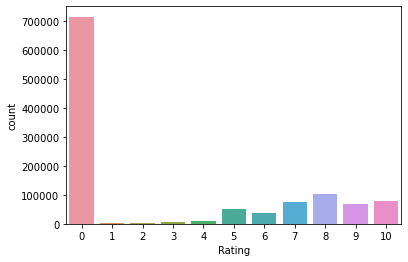

In [38]:
#Visualizing the ratings column.
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(ratings.toPandas().Rating)
plt.show()

- We can clearly see that dataset is Highly Imbalnced.
- Books are rated either 0 or mostly above 6.

### Merging books and ratings dataframe for the task


In [39]:
books_ratings_df = ratings.join(books_df, on=['ISBN'], how='left_outer')

In [40]:
#dropping nan if any
books_ratings_df=books_ratings_df.na.drop()

In [41]:
#no.of rows in the final DataFrame
books_ratings_df.count()

1031163

In [42]:
#no.of columns in the final DataFrame
len(books_ratings_df.columns)

7

In [43]:
books_ratings_df.show(5)

+----------+-------+------+--------------------+-------------+----+--------------------+
|      ISBN|User_ID|Rating|               Title|       Author|Year|           Publisher|
+----------+-------+------+--------------------+-------------+----+--------------------+
|0002234947|  39608|     0|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|
|0002234947| 219445|     0|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|
|0002234947| 227275|     0|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|
|0002243687| 271542|     0|Brother Frank's g...|W. P Kinsella|1994|       HarperCollins|
|0002257084| 261105|     0|          Dolce Vita| Iseult Teran|1999|HarperCollins Pub...|
+----------+-------+------+--------------------+-------------+----+--------------------+
only showing top 5 rows



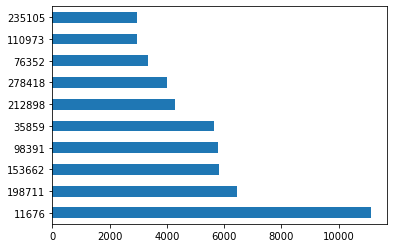

In [44]:
#Visualizing Top 10 Users wh0 rated most of the books in the datset
books_ratings_df.toPandas()['User_ID'].value_counts()[:10].plot(kind='barh')

In [45]:
#Let's see Top 10 popular books based on no.of ratings provided.
r=books_ratings_df.toPandas()['Title'].value_counts()[0:10]

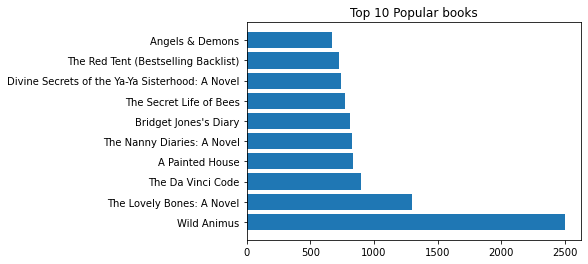

In [46]:
r=r.to_frame().reset_index()
r.columns=['Title','Count']
plt.barh(r.Title,r.Count)
plt.title("Top 10 Popular books")
plt.show()

- Wild Animus is the most Popular book.

### Converting Sting Columns to Numeric

In [47]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [48]:
books_ratings_df.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- User_ID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Publisher: string (nullable = true)



In [49]:
indexer = StringIndexer().setInputCol("ISBN").setOutputCol("ISBN_Index").fit(books_ratings_df)
books_ratings_df = indexer.transform(books_ratings_df)

In [50]:
indexer = StringIndexer().setInputCol("Title").setOutputCol("Title_Index").fit(books_ratings_df)
books_ratings_df = indexer.transform(books_ratings_df)

In [51]:
indexer = StringIndexer().setInputCol("Author").setOutputCol("Author_Index").fit(books_ratings_df)
books_ratings_df = indexer.transform(books_ratings_df)

In [52]:
indexer = StringIndexer().setInputCol("Publisher").setOutputCol("Publisher_Index").fit(books_ratings_df)
books_ratings_df = indexer.transform(books_ratings_df)

In [53]:
books_ratings_df.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- User_ID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- ISBN_Index: double (nullable = false)
 |-- Title_Index: double (nullable = false)
 |-- Author_Index: double (nullable = false)
 |-- Publisher_Index: double (nullable = false)



##### Let's Assemble all together to get features.

In [55]:
assembler = VectorAssembler(inputCols=["ISBN_Index","User_ID","Title_Index","Author_Index","Publisher_Index"],outputCol="features")
books_ratings_df= assembler.transform(books_ratings_df)
books_ratings_df= books_ratings_df.select("User_ID","ISBN","Title","Author","Year","Publisher","features","Rating")
books_ratings_df.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- Rating: integer (nullable = true)



In [56]:
books_ratings_df.show(5)

+-------+----------+--------------------+-------------+----+--------------------+--------------------+------+
|User_ID|      ISBN|               Title|       Author|Year|           Publisher|            features|Rating|
+-------+----------+--------------------+-------------+----+--------------------+--------------------+------+
|  39608|0002234947|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|[63518.0,39608.0,...|     0|
| 219445|0002234947|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|[63518.0,219445.0...|     0|
| 227275|0002234947|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|[63518.0,227275.0...|     0|
| 271542|0002243687|Brother Frank's g...|W. P Kinsella|1994|       HarperCollins|[237471.0,271542....|     0|
| 261105|0002257084|          Dolce Vita| Iseult Teran|1999|HarperCollins Pub...|[161284.0,261105....|     0|
+-------+----------+--------------------+-------------+----+--------------------+--------------------+------+
only showi

In [57]:
#Value counts per Each Rating
books_ratings_df.groupby("Rating").count().show()

+------+------+
|Rating| count|
+------+------+
|     1|  1481|
|     6| 31690|
|     3|  5118|
|     5| 45354|
|     9| 60775|
|     4|  7617|
|     8| 91804|
|     7| 66404|
|    10| 71226|
|     2|  2375|
|     0|647319|
+------+------+



- As we can see the dataset is more imbalnced , and there are more value counts for rating 0.
- will convert the rating column with 1 if rated above 5 else 0.

In [62]:
#If rating is greater than 5 Rating_Changed=1, else 0
books_ratings_df1= books_ratings_df.withColumn("Rating_Changed",F.when(books_ratings_df.Rating >5 ,1).otherwise(0))

In [63]:
books_ratings_df1.show(5)

+-------+----------+--------------------+-------------+----+--------------------+--------------------+------+--------------+
|User_ID|      ISBN|               Title|       Author|Year|           Publisher|            features|Rating|Rating_Changed|
+-------+----------+--------------------+-------------+----+--------------------+--------------------+------+--------------+
|  39608|0002234947|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|[63518.0,39608.0,...|     0|             0|
| 219445|0002234947|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|[63518.0,219445.0...|     0|             0|
| 227275|0002234947|Miss Hobbema Pageant|W.P. Kinsella|1990|Harpercollins Juv...|[63518.0,227275.0...|     0|             0|
| 271542|0002243687|Brother Frank's g...|W. P Kinsella|1994|       HarperCollins|[237471.0,271542....|     0|             0|
| 261105|0002257084|          Dolce Vita| Iseult Teran|1999|HarperCollins Pub...|[161284.0,261105....|     0|             0|


In [66]:
#dropping Rating column from the dataframe
books_ratings_df1=books_ratings_df1.drop("Rating")

In [65]:
#getting value counts of Ratings after changed them to binary,
books_ratings_df1.groupby("Rating_changed").count().show()

+--------------+------+
|Rating_changed| count|
+--------------+------+
|             1|321899|
|             0|709264|
+--------------+------+



- We can see that the data is still unbalaned, Will create a new column ClassWeights to give more weightage for the minority class.

# 1.2 ALS

In [69]:
from pyspark.ml.recommendation import ALS

In [70]:
#Converting ISBn=N from string to numeric, as ALS only accepts numeric columns
indexer = StringIndexer().setInputCol("ISBN").setOutputCol("ISBN_Index").fit(books_ratings_df1)
books_ratings_df_als = indexer.transform(books_ratings_df1)

In [72]:
#randomly splitting the data
als_train, als_test = books_ratings_df_als.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " , (als_train.count()))
print("Test Dataset Count: " , als_test.count())

Training Dataset Count:  722156
Test Dataset Count:  309007


In [73]:
#books_ratings_df_als = books_ratings_df_als.withColumnRenamed("Rating_changed","label")

In [76]:
#Fitting the ALS model
als=ALS(maxIter=5,regParam=0.01,userCol="User_ID",itemCol="ISBN_Index",ratingCol="Rating_Changed",coldStartStrategy="drop",nonnegative=True)
als_model=als.fit(als_train)

#### ALS evaluation

In [77]:
#importing RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
#transforming test
als_predictions= als_model.transform(als_test)
#defining evaluator
evaluator= RegressionEvaluator(metricName='mse',labelCol='Rating_Changed',predictionCol='prediction')
#evaluating als predictions
mse = evaluator.evaluate(als_predictions)
#printing the MSE score
print("MSE:",mse)

MSE: 0.24347313717705937


In [ ]:
#user_recom= als_model.recommendForAllUsers(10)
#user_recom.show()

# 1.3. Logistic Regression

In [78]:
#importing LogisticRegression
from pyspark.ml.classification import LogisticRegression

In [79]:
#randomly splitting the data
lr_train, lr_test = books_ratings_df1.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " , (lr_train.count()))
print("Test Dataset Count: " , lr_test.count())

Training Dataset Count:  722156
Test Dataset Count:  309007


In [80]:
#defining the lr model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Rating_Changed', maxIter=10)
#fitting lr model
lr_model = lr.fit(lr_train)

In [81]:
#train predictions
train_predict = lr_model.transform(lr_train)
#test predictions
test_predict = lr_model.transform(lr_test)

#### LR model Evaluation

In [83]:
from pyspark.ml.evaluation import  BinaryClassificationEvaluator
lr_evaluator = BinaryClassificationEvaluator(labelCol='Rating_Changed')

In [84]:
print("Train AUC:",lr_evaluator.evaluate(train_predict))
print("Test AUC:",lr_evaluator.evaluate(test_predict))

Train AUC: 0.532607790478523
Test AUC: 0.5331504039257311


- As the data is more un balanced , lr model has got 53% AUC .
- Let's add class weights and fit the LR model again.

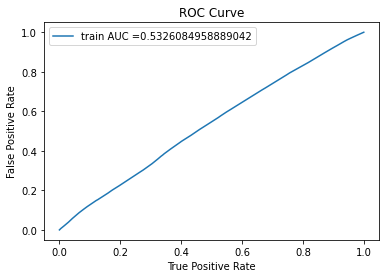

In [106]:
trainingSummary = lr_model.summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'], label="train AUC ="+str(trainingSummary.areaUnderROC))
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve of Train')
plt.legend()
plt.show()

#### ClassWeights

In [88]:
negatives = books_ratings_df1.where(books_ratings_df1.Rating_Changed == 0).count()
positives = books_ratings_df1.where(books_ratings_df1.Rating_Changed == 1).count()

In [90]:
negative_ratio= negatives / books_ratings_df1.count()
positive_ratio= positives / books_ratings_df1.count()

In [91]:
print("Negative class Ratio :",negative_ratio)
print("Positive class Ratio :",positive_ratio)

Negative class Ratio : 0.6878291792859131
Positive class Ratio : 0.3121708207140869


In [98]:
books_ratings_df2 = books_ratings_df1.withColumn("ClassWeights",F.when(books_ratings_df1.Rating_Changed ==0,positive_ratio).when(books_ratings_df1.Rating_Changed ==1,(1-positive_ratio)))

### LR with ClassWeights

In [100]:
lr_train1, lr_test1 = books_ratings_df2.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " , (lr_train1.count()))
print("Test Dataset Count: " , lr_test1.count())

Training Dataset Count:  722156
Test Dataset Count:  309007


In [101]:
lr_1 = LogisticRegression(featuresCol = 'features', labelCol = 'Rating_Changed', maxIter=10,weightCol="ClassWeights")
lr_bal_model = lr_1.fit(lr_train1)

In [102]:
bal_train_predict = lr_bal_model.transform(lr_train1)
bal_test_predict = lr_bal_model.transform(lr_test1)

In [104]:
lr_evaluator1 = BinaryClassificationEvaluator(labelCol='Rating_Changed')

In [105]:
print("Train Accuracy:",lr_evaluator1.evaluate(bal_train_predict))
print("Test Accuracy:",lr_evaluator1.evaluate(bal_test_predict))

Train Accuracy: 0.5326680160666527
Test Accuracy: 0.5332191500891664


- AUC doesn't improve from 53 with default parameters.
- We can try to increase AUC by doing cross validation with different ranges of parameters.
- We can also try to increase the AUc by adding some more useful features to the model.

In [ ]:
#sc.stop()

### END